In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os 
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict 
from GRU_model import GRUNet

In [2]:
#TODO make supervised learning dataset from csv files
#TODO build dataloader
solar_data = pd.read_csv('data\\training_data\\train_pv_new.csv', delimiter=',').to_numpy()
wind_data = pd.read_csv('data\\training_data\\train_wind_new.csv', delimiter=',').to_numpy()
solar_test_data = pd.read_csv('data\\test_data\\test_pv_new.csv', delimiter=',').to_numpy()
wind_test_data = pd.read_csv('data\\test_data\\test_wind_new.csv', delimiter=',').to_numpy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead

    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)
    return inputs, labels

In [4]:
#create dataset
class EnergyDataset(Dataset):
    def __init__(self, inputs, output):
        self.inputs = inputs
        self.output = output

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx].copy(), self.output[idx].copy()

In [5]:
criterion = nn.MSELoss()
pv_train_X, pv_train_y = move_sliding_window(solar_data, 24, range(solar_data.shape[1]), 0, 1)
pv_dataset = EnergyDataset(pv_train_X, pv_train_y)

pv_test_X, pv_test_y = move_sliding_window(solar_test_data, 24, range(solar_test_data.shape[1]), 0, 1)
pv_test_dataset = EnergyDataset(pv_test_X, pv_test_y)

(26280, 24, 18) (26280, 1)
(8736, 24, 18) (8736, 1)


In [6]:
wind_train_X, wind_train_y = move_sliding_window(wind_data, 24, range(wind_data.shape[1]), 0, 1)
wind_dataset = EnergyDataset(wind_train_X, wind_train_y)

wind_test_X, wind_test_y = move_sliding_window(wind_test_data, 24, range(wind_test_data.shape[1]), 0, 1)
wind_test_dataset = EnergyDataset(wind_test_X, wind_test_y)

(26280, 24, 18) (26280, 1)
(8736, 24, 18) (8736, 1)


In [135]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [136]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.0001)

In [58]:
def train_one_epoch(model, dataloader, criterion, optimizer, apply_grad_clip, grad_clip_param):
    model.train()
    running_loss = 0.0
    for i, (inputs, target) in enumerate(dataloader):
     
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        hidden = model.init_hidden(inputs.size(0)).to(device)
        outputs, hidden = model(inputs.float(), hidden)
        loss = criterion(outputs, target.float())
        loss.backward()
        if apply_grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_param)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [59]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs, apply_grad_clip, grad_clip_param):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, apply_grad_clip, grad_clip_param)
        #val_loss = evaluate(model, val_dataloader, criterion)
        train_losses.append(train_loss)
        #val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs} Train Loss: {train_loss:.4f}")# Validation Loss: {val_loss:.4f}")
    return train_losses

In [7]:
def evaluate(model, dataloader, criterion):
    model.eval()
    outputs = []
    targets = []
    losses = []

    
    # get data of test data for each state
    
    
        # predict outputs
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            h = model.init_hidden(inputs.size(0)).to(device)
            
            # drop first dimension of h
           
           # print(inputs.shape, h.shape)
            out, h = model(inputs, h)
            
            loss = criterion(labels, out)
            print(f"Loss: {loss.item()}")
            losses.append(loss.item())
            outputs.append(out.cpu().numpy())
            targets.append(labels.cpu().numpy())

   
    
    
    # list of of targets/outputs for each state
    return outputs, targets, losses

In [140]:
def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (input, target) in enumerate(dataloader):
            inputs, target = inputs.to(device), target.to(device)
            hidden = model.init_hidden(input.size(0)).to(device)
            outputs, hidden = model(inputs.float(), hidden)
            loss = criterion(outputs, target.float())
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [141]:
model = GRUNet(input_dim=18, hidden_dim=64, output_dim=1, n_layers=1, drop_prob=.66).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0010256038174393189, weight_decay=0.00011840686132512298)
pv_dataloader = DataLoader(pv_dataset, batch_size=64, shuffle=False)

c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.66 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [142]:
train_losses_pv_1h = train_model(model, pv_dataloader, criterion, optimizer, 200, True, 2)

Epoch 1/200 Train Loss: 0.0403
Epoch 2/200 Train Loss: 0.0073
Epoch 3/200 Train Loss: 0.0038
Epoch 4/200 Train Loss: 0.0026
Epoch 5/200 Train Loss: 0.0019
Epoch 6/200 Train Loss: 0.0016
Epoch 7/200 Train Loss: 0.0014
Epoch 8/200 Train Loss: 0.0012
Epoch 9/200 Train Loss: 0.0011
Epoch 10/200 Train Loss: 0.0011
Epoch 11/200 Train Loss: 0.0010
Epoch 12/200 Train Loss: 0.0010
Epoch 13/200 Train Loss: 0.0010
Epoch 14/200 Train Loss: 0.0009
Epoch 15/200 Train Loss: 0.0009
Epoch 16/200 Train Loss: 0.0009
Epoch 17/200 Train Loss: 0.0009
Epoch 18/200 Train Loss: 0.0009
Epoch 19/200 Train Loss: 0.0008
Epoch 20/200 Train Loss: 0.0008
Epoch 21/200 Train Loss: 0.0008
Epoch 22/200 Train Loss: 0.0008
Epoch 23/200 Train Loss: 0.0008
Epoch 24/200 Train Loss: 0.0008
Epoch 25/200 Train Loss: 0.0008
Epoch 26/200 Train Loss: 0.0008
Epoch 27/200 Train Loss: 0.0008
Epoch 28/200 Train Loss: 0.0007
Epoch 29/200 Train Loss: 0.0008
Epoch 30/200 Train Loss: 0.0007
Epoch 31/200 Train Loss: 0.0007
Epoch 32/200 Trai

In [181]:
# get the rmse of the mse loss of training
train_losses_pv_1h = np.array(train_losses_pv_1h)
train_rmse = np.mean(np.sqrt(train_losses_pv_1h))
print(f"Train RMSE: {train_rmse}")
# scale it back to the original scale
#train_rmse = scaler.inverse_transform(train_rmse.reshape(-1, 1)).flatten()

Train RMSE: 0.026399936363582458


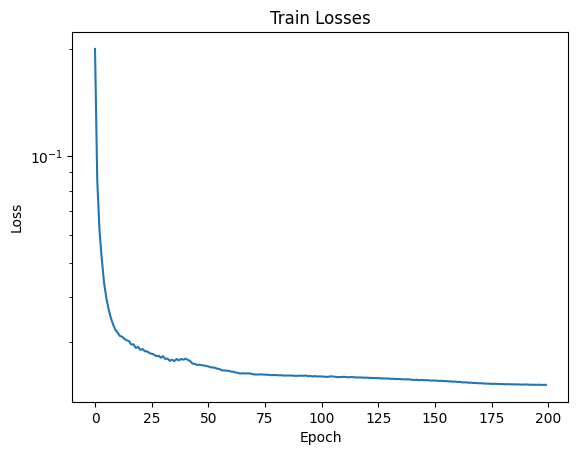

In [180]:
#get rmse of train losses
plt.plot(np.sqrt(train_losses_pv_1h))
#adjust sclaing of y axis
plt.yscale('log')
plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


In [15]:
import pickle
import io

In [25]:
path = 'models/checkpoint_000199/data.pkl'
def fix(map_loc):
    # Closure rather than a lambda to preserve map_loc 
    return lambda b: torch.load(io.BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = io.BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

data = mapped_loads(open(path, 'rb').read(), map_location='cpu')

In [30]:
pv_test_dataloader = DataLoader(pv_test_dataset, batch_size=1, shuffle=False)

In [31]:
#print(data['net_state_dict'])
alt_model_pv = GRUNet(input_dim=18, hidden_dim=64, output_dim=1, n_layers=1, drop_prob=.66).to(device)
alt_model_pv.load_state_dict(data['net_state_dict'])

c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.66 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [32]:
outputs_alt, targets_alt, test_loss_alt = evaluate(alt_model_pv, pv_test_dataloader, criterion)

Loss: 0.00013402302283793688
Loss: 0.0001056529363268055
Loss: 5.435900675365701e-05
Loss: 7.0840040280018e-05
Loss: 2.4069408027571626e-05
Loss: 1.5643963706679642e-05
Loss: 0.00011115083907498047
Loss: 0.0006658455240540206
Loss: 0.00017075601499527693
Loss: 0.0008312715217471123
Loss: 5.961919669061899e-06
Loss: 0.0001604015560587868
Loss: 4.616859314410249e-06
Loss: 6.233750173123553e-05
Loss: 0.001431897864677012
Loss: 0.00019509144476614892
Loss: 0.00028055376606062055
Loss: 0.0006504050106741488
Loss: 2.1792425286548678e-07
Loss: 6.269971208894276e-08
Loss: 2.802264134516008e-06
Loss: 3.274249320384115e-05
Loss: 3.364770600455813e-05
Loss: 1.3900445992476307e-05
Loss: 2.8015341740683652e-05
Loss: 5.67660536034964e-05
Loss: 0.00014778885815758258
Loss: 0.00024264164676424116
Loss: 0.0004994032206013799
Loss: 0.00027938891435042024
Loss: 8.90225637704134e-05
Loss: 5.265344498184277e-07
Loss: 3.3919470752152847e-06
Loss: 0.0019164978293702006
Loss: 0.0006894508260302246
Loss: 7.898

In [34]:
model_retrained_pv = GRUNet(input_dim=18, hidden_dim=64, output_dim=1, n_layers=1, drop_prob=.66).to(device)
model_retrained_pv.load_state_dict(torch.load('solar_retrained.pth'))
outputs_retrained_pv, targets_retrained_pv, test_loss_retrained_pv = evaluate(model_retrained_pv, pv_test_dataloader, criterion)

Loss: 0.0006251478334888816
Loss: 0.0002632848045323044
Loss: 7.791226380504668e-05
Loss: 1.994672857108526e-05
Loss: 4.42704840679653e-05
Loss: 1.8399367036181502e-05
Loss: 0.00030617640004493296
Loss: 0.0008093183860182762
Loss: 0.0001273648376809433
Loss: 0.0011917477240785956
Loss: 9.46444743021857e-06
Loss: 7.254380761878565e-05
Loss: 8.198418072424829e-06
Loss: 2.18506102100946e-06
Loss: 0.0024048651102930307
Loss: 0.00013971283624414355
Loss: 0.00013043844955973327
Loss: 0.00026114212232641876
Loss: 1.5288140275515616e-05
Loss: 6.408032731997082e-06
Loss: 2.3072539079294074e-06
Loss: 3.828587580301246e-07
Loss: 2.2129916033009067e-06
Loss: 2.29675952141406e-05
Loss: 1.0456244126544334e-05
Loss: 2.102739927067887e-05
Loss: 0.0001617677917238325
Loss: 0.00021782996191177517
Loss: 0.0005095938686281443
Loss: 0.00025337564875371754
Loss: 0.00013176789798308164
Loss: 2.9300065307324985e-06
Loss: 1.4037673281563912e-05
Loss: 0.0015499969013035297
Loss: 0.00047901488142088056
Loss: 4.8

In [35]:
outputs_alt_pv = np.array(outputs_alt).reshape(-1, 1)
targets_alt_pv = np.array(targets_alt).reshape(-1, 1)

outputs_retrained_pv = np.array(outputs_retrained_pv).reshape(-1, 1)
targets_retrained_pv = np.array(targets_retrained_pv).reshape(-1, 1)

In [36]:
pd.DataFrame(outputs_alt_pv).to_csv('outputs_alt_pv.csv')
pd.DataFrame(targets_alt_pv).to_csv('targets_alt_pv.csv')
pd.DataFrame(outputs_retrained_pv).to_csv('outputs_retrained_pv.csv')
pd.DataFrame(targets_retrained_pv).to_csv('targets_retrained_pv.csv')

In [8]:
wind_dataloader = DataLoader(wind_dataset, batch_size=16, shuffle=False)
wind_dataloader_test = DataLoader(wind_test_dataset, batch_size=1, shuffle=False)

In [17]:
data = mapped_loads(open('models\\checkpoint_000199_wind_1h\\data.pkl', 'rb').read(), map_location='cpu')
#print(data['net_state_dict'])
alt_model_w = GRUNet(input_dim=18, hidden_dim=128, output_dim=1, n_layers=1, drop_prob=.66).to(device)
alt_model_w.load_state_dict(data['net_state_dict'])


<All keys matched successfully>

In [18]:
output_alt_wind, targets_alt_wind, test_loss_alt_wind = evaluate(alt_model_w, wind_dataloader_test, criterion)


Loss: 7.204676512628794e-05
Loss: 0.00039011662011034787
Loss: 0.0008891112520359457
Loss: 0.001305876881815493
Loss: 0.004459094721823931
Loss: 0.002520115114748478
Loss: 2.7554656298889313e-06
Loss: 0.001665586605668068
Loss: 0.002774190390482545
Loss: 0.0019590118899941444
Loss: 0.0033724368549883366
Loss: 0.0008614337421022356
Loss: 0.00299182441085577
Loss: 7.934005225251894e-06
Loss: 0.0012214662274345756
Loss: 0.002638016128912568
Loss: 0.004135210532695055
Loss: 0.004997030831873417
Loss: 0.003402604488655925
Loss: 1.042740677803522e-06
Loss: 0.0004626700538210571
Loss: 0.0007031309651210904
Loss: 0.0026417155750095844
Loss: 0.000367556931450963
Loss: 0.0001801632170099765
Loss: 0.0058298008516430855
Loss: 6.8716462919837795e-06
Loss: 0.0013214490609243512
Loss: 0.006467383820563555
Loss: 0.02081354148685932
Loss: 0.03803355246782303
Loss: 0.005291587207466364
Loss: 7.893093425082043e-06
Loss: 0.00038534216582775116
Loss: 0.0011078966781497002
Loss: 0.005392140243202448
Loss: 0

In [208]:
wind_retrained = GRUNet(input_dim=18, hidden_dim=128, output_dim=1, n_layers=1, drop_prob=.66).to(device)
wind_retrained_optimizer = torch.optim.Adam(wind_retrained.parameters(), lr=0.0018900905727546541, weight_decay=0.00011263449766971877)

c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.66 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [209]:
loss_wind_retrained = train_model(wind_retrained, wind_dataloader, criterion, wind_retrained_optimizer, 200, True, 2)

Epoch 1/200 Train Loss: 0.0155
Epoch 2/200 Train Loss: 0.0031
Epoch 3/200 Train Loss: 0.0020
Epoch 4/200 Train Loss: 0.0021
Epoch 5/200 Train Loss: 0.0019
Epoch 6/200 Train Loss: 0.0017
Epoch 7/200 Train Loss: 0.0017
Epoch 8/200 Train Loss: 0.0015
Epoch 9/200 Train Loss: 0.0016
Epoch 10/200 Train Loss: 0.0018
Epoch 11/200 Train Loss: 0.0018
Epoch 12/200 Train Loss: 0.0011
Epoch 13/200 Train Loss: 0.0011
Epoch 14/200 Train Loss: 0.0014
Epoch 15/200 Train Loss: 0.0017
Epoch 16/200 Train Loss: 0.0014
Epoch 17/200 Train Loss: 0.0011
Epoch 18/200 Train Loss: 0.0011
Epoch 19/200 Train Loss: 0.0013
Epoch 20/200 Train Loss: 0.0011
Epoch 21/200 Train Loss: 0.0013
Epoch 22/200 Train Loss: 0.0019
Epoch 23/200 Train Loss: 0.0011
Epoch 24/200 Train Loss: 0.0010
Epoch 25/200 Train Loss: 0.0010
Epoch 26/200 Train Loss: 0.0011
Epoch 27/200 Train Loss: 0.0010
Epoch 28/200 Train Loss: 0.0010
Epoch 29/200 Train Loss: 0.0012
Epoch 30/200 Train Loss: 0.0011
Epoch 31/200 Train Loss: 0.0010
Epoch 32/200 Trai

Train RMSE: 0.030560915493054973


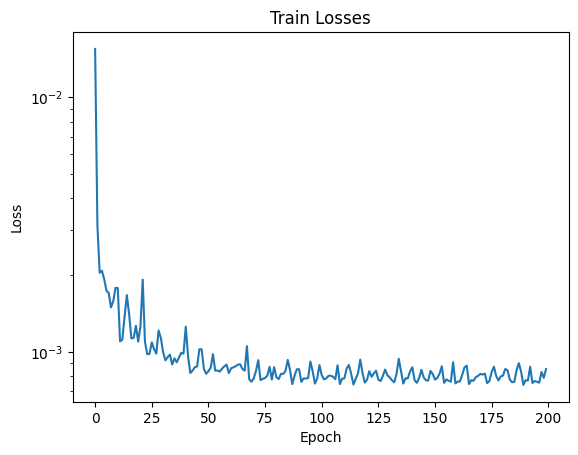

In [214]:
loss_wind_retrained = np.array(loss_wind_retrained)
train_rmse_wind = np.mean(np.sqrt(loss_wind_retrained))
print(f"Train RMSE: {train_rmse_wind}")

plt.plot(loss_wind_retrained)
plt.yscale('log')
plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [216]:
torch.save(wind_retrained.state_dict(), 'wind_retrained.pth')
torch.save(model.state_dict(), 'solar_retrained.pth')

In [19]:
retrained_wind_1hmodel = GRUNet(input_dim=18, hidden_dim=128, output_dim=1, n_layers=1, drop_prob=.66).to(device)
retrained_wind_1hmodel.load_state_dict(torch.load('wind_retrained.pth'))
output_retrained_wind, targets_retrained_wind, test_loss_retrained_wind = evaluate(retrained_wind_1hmodel, wind_dataloader_test, criterion)

c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.66 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Loss: 0.00047836379962973297
Loss: 0.0015833049546927214
Loss: 0.002224844181910157
Loss: 0.0003101512847933918
Loss: 0.006139697507023811
Loss: 0.0005810587899759412
Loss: 5.6195589422713965e-05
Loss: 0.00043167389230802655
Loss: 0.00173142459243536
Loss: 0.0036549486685544252
Loss: 0.001595060690306127
Loss: 0.000459587958175689
Loss: 0.0012516246642917395
Loss: 0.0004890175187028944
Loss: 9.421492723049596e-05
Loss: 0.00039314807509072125
Loss: 0.0005895218346267939
Loss: 0.00048228437663055956
Loss: 2.8246751753613353e-05
Loss: 0.002540221903473139
Loss: 0.00012658840569201857
Loss: 0.0036461669951677322
Loss: 0.00544700725004077
Loss: 1.1333122529322281e-07
Loss: 0.0016410937532782555
Loss: 0.010486176237463951
Loss: 0.0008275551372207701
Loss: 0.004426266998052597
Loss: 0.0019779319409281015
Loss: 0.011323886923491955
Loss: 0.016884690150618553
Loss: 0.0012379701947793365
Loss: 0.00687867496162653
Loss: 0.0015741243259981275
Loss: 0.0003524732601363212
Loss: 0.0007337751449085772

In [20]:
output_alt_wind = np.array(output_alt_wind).reshape(-1, 1)
targets_alt_wind = np.array(targets_alt_wind).reshape(-1, 1)

output_retrained_wind = np.array(output_retrained_wind).reshape(-1, 1)
targets_retrained_wind = np.array(targets_retrained_wind).reshape(-1, 1)

In [46]:

pd.DataFrame(output_alt_wind).to_csv('outputs_wind_alt.csv', index=False)
pd.DataFrame(targets_alt_wind).to_csv('targets_wind_alt.csv', index=False)
pd.DataFrame(output_retrained_wind).to_csv('outputs_wind_retrained.csv', index=False)
pd.DataFrame(targets_retrained_wind).to_csv('targets_wind_retrained.csv', index=False)

In [75]:
print('Retrained Loss')
print('Solar:', 0.03156342820417326 **2)
print(f'Wind: {0.03160696125855822**2.:4f}')

Retrained Loss
Solar: 0.00099625
Wind: 0.000999


In [40]:
print('Losses')
print(f'PV Alt: {np.mean(test_loss_alt)}')
print(f'PV Retrained: {np.mean(test_loss_retrained_pv)}')
print(f'Wind Alt: {np.mean(test_loss_alt_wind)}')
print(f'Wind Retrained: {np.mean(test_loss_retrained_wind)}')


Losses
PV Alt: 0.0017654383854324432
PV Retrained: 0.0014719593611863255
Wind Alt: 0.0011244386333067193
Wind Retrained: 0.001402099097170362


In [45]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print('Test set RMSE')
print(f'PV Alt: {rmse(outputs_alt_pv, targets_alt_pv)}')
print(f'PV Retrained: {rmse(outputs_retrained_pv, targets_retrained_pv)}')
print(f'Wind Alt: {rmse(output_alt_wind, targets_alt_wind)}')
print(f'Wind Retrained: {rmse(output_retrained_wind, targets_retrained_wind)}')


Test set RMSE
PV Alt: 0.042017120867967606
PV Retrained: 0.03836612030863762
Wind Alt: 0.03353264927864075
Wind Retrained: 0.03744461387395859


In [61]:
pv_train_X_24, pv_train_y_24 = move_sliding_window(solar_data, 72, range(solar_data.shape[1]), 0, 24)
dataset_pv_24 = EnergyDataset(pv_train_X_24, pv_train_y_24)
train_dataloader_pv_24 = DataLoader(dataset_pv_24, batch_size=16, shuffle=False)

(26209, 72, 18) (26209, 1)


In [62]:
alt_model_pv_24 = GRUNet(input_dim=18, hidden_dim=16, output_dim=1, n_layers=1, drop_prob=.3).to(device)
params_pv_24 = mapped_loads(open('models\\checkpoint_000199_solar_24\\data.pkl', 'rb').read(), map_location='cpu')
alt_model_pv_24.load_state_dict(params_pv_24['net_state_dict'])

c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [63]:
model_pv_24 = GRUNet(input_dim=18, hidden_dim=16, output_dim=1, n_layers=1, drop_prob=.5).to(device) 
optimizer_pv_24 = torch.optim.Adam(model_pv_24.parameters(), lr=0.0010175919036803488, weight_decay=0.0007019087081185545)

c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [64]:
train_losses_pv_24 = train_model(model_pv_24, train_dataloader_pv_24, criterion, optimizer_pv_24, 200, True, 2)

Epoch 1/200 Train Loss: 0.0374
Epoch 2/200 Train Loss: 0.0182
Epoch 3/200 Train Loss: 0.0176
Epoch 4/200 Train Loss: 0.0171
Epoch 5/200 Train Loss: 0.0169
Epoch 6/200 Train Loss: 0.0168
Epoch 7/200 Train Loss: 0.0167
Epoch 8/200 Train Loss: 0.0166
Epoch 9/200 Train Loss: 0.0165
Epoch 10/200 Train Loss: 0.0165
Epoch 11/200 Train Loss: 0.0164
Epoch 12/200 Train Loss: 0.0163
Epoch 13/200 Train Loss: 0.0163
Epoch 14/200 Train Loss: 0.0162
Epoch 15/200 Train Loss: 0.0162
Epoch 16/200 Train Loss: 0.0162
Epoch 17/200 Train Loss: 0.0161
Epoch 18/200 Train Loss: 0.0161
Epoch 19/200 Train Loss: 0.0161
Epoch 20/200 Train Loss: 0.0161
Epoch 21/200 Train Loss: 0.0161
Epoch 22/200 Train Loss: 0.0161
Epoch 23/200 Train Loss: 0.0160
Epoch 24/200 Train Loss: 0.0160
Epoch 25/200 Train Loss: 0.0160
Epoch 26/200 Train Loss: 0.0160
Epoch 27/200 Train Loss: 0.0160
Epoch 28/200 Train Loss: 0.0160
Epoch 29/200 Train Loss: 0.0160
Epoch 30/200 Train Loss: 0.0160
Epoch 31/200 Train Loss: 0.0160
Epoch 32/200 Trai

In [65]:
#save model
torch.save(model_pv_24.state_dict(), 'solar_retrained_24.pth')

In [66]:
outputs_retrained_pv_24, targets_retrained_pv_24, test_loss_retrained_pv_24 = evaluate(model_pv_24, pv_test_dataloader, criterion)
outputs_alt_pv_24, targets_alt_pv_24, test_loss_alt_pv_24 = evaluate(alt_model_pv_24, pv_test_dataloader, criterion)

Loss: 0.000726778176613152
Loss: 0.0008784706587903202
Loss: 0.0008781314827501774
Loss: 0.0006312100449576974
Loss: 0.00032290254603140056
Loss: 9.204070374835283e-05
Loss: 1.653470280871261e-05
Loss: 2.7249601771472953e-05
Loss: 3.481100429780781e-05
Loss: 0.005781116429716349
Loss: 0.015717269852757454
Loss: 0.00987770315259695
Loss: 0.0007400758331641555
Loss: 0.003467314410954714
Loss: 0.006243919022381306
Loss: 0.011439625173807144
Loss: 0.008197263814508915
Loss: 0.0015920817386358976
Loss: 0.00018208521942142397
Loss: 6.6035381678375416e-06
Loss: 2.9802129120071186e-06
Loss: 5.411406891653314e-05
Loss: 0.00021776839275844395
Loss: 0.0004291234945412725
Loss: 0.0006620367057621479
Loss: 0.0008432199829258025
Loss: 0.0008389261201955378
Loss: 0.0006259976071305573
Loss: 0.00031367261544801295
Loss: 0.00010315715917386115
Loss: 2.531325662857853e-05
Loss: 3.163335713907145e-05
Loss: 7.798067235853523e-05
Loss: 0.0014229711377993226
Loss: 0.006330179516226053
Loss: 0.00279454118572

In [67]:
outputs_retrained_pv_24 = np.array(outputs_retrained_pv_24).reshape(-1, 1)
targets_retrained_pv_24 = np.array(targets_retrained_pv_24).reshape(-1, 1)
outputs_alt_pv_24 = np.array(outputs_alt_pv_24).reshape(-1, 1)
targets_alt_pv_24 = np.array(targets_alt_pv_24).reshape(-1, 1)

In [69]:
print('Retrained RMSE for 24h')
print('Solar:', np.sqrt(np.mean(train_losses_pv_24)))


Retrained RMSE for 24h
Solar: 0.12635537333924737


Text(0, 0.5, 'Loss')

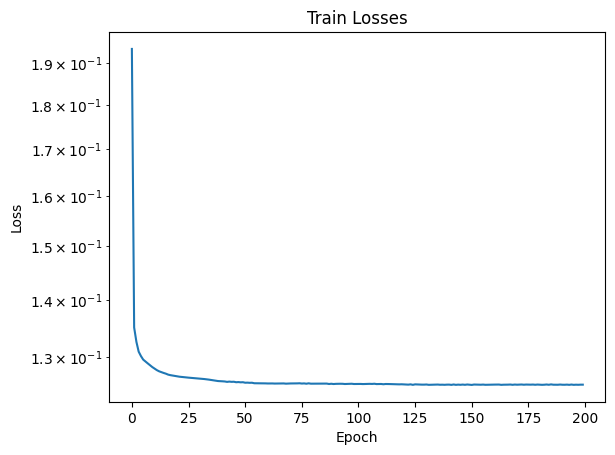

In [70]:
plt.plot(np.sqrt(train_losses_pv_24))
plt.yscale('log')
plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [71]:
print('Test loss for 24h')
print(f'PV Alt: {np.mean(test_loss_alt_pv_24)}')
print(f'PV Retrained: {np.mean(test_loss_retrained_pv_24)}')

Test loss for 24h
PV Alt: 0.033522706266312444
PV Retrained: 0.033002388878346896


In [72]:
print('RMSE for 24h')   
print(f'PV Alt: {rmse(outputs_alt_pv_24, targets_alt_pv_24)}')
print(f'PV Retrained: {rmse(outputs_retrained_pv_24, targets_retrained_pv_24)}')

RMSE for 24h
PV Alt: 0.18309207260608673
PV Retrained: 0.1816655844449997


In [73]:
pd.DataFrame(outputs_retrained_pv_24).to_csv('outputs_retrained_pv_24.csv', index=False)
pd.DataFrame(targets_retrained_pv_24).to_csv('targets_retrained_pv_24.csv', index=False)
pd.DataFrame(outputs_alt_pv_24).to_csv('outputs_alt_pv_24.csv', index=False)
pd.DataFrame(targets_alt_pv_24).to_csv('targets_alt_pv_24.csv', index=False)